In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pickle
import importlib
import logging

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.baseclass import BaseClass
from utilities.baseevaluation import BaseEvaluation
from utilities.baseplot import BasePlot
from utilities.ivevaluation import IVEvaluation
from utilities.basefunctions import bin_y_over_x
from utilities.pincodefit import get_pincode

importlib.reload(sys.modules["utilities.baseclass"])
importlib.reload(sys.modules["utilities.baseevaluation"])
importlib.reload(sys.modules["utilities.baseplot"])
importlib.reload(sys.modules["utilities.ivevaluation"])
importlib.reload(sys.modules["utilities.pincodefit"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

importlib.reload(logging)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s")
# pip install numpy matplotlib scipy tqdm torch hdf5view h5py PySide6


In [2]:
eva = BaseClass()

eva.title = "Breaking Study"
eva.sub_folder = "breaking study"

eva.loadData()
exp = eva.up_sweep | eva.mapped

(base) ... BaseClass initialized.
(base) Breaking Study
(base) loadData()


In [3]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
V_gap = 189e-6      # V
Delta = V_gap*e     # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A
nu = 15e9         # Hz

In [4]:
exp['current'].shape

(319, 1198)

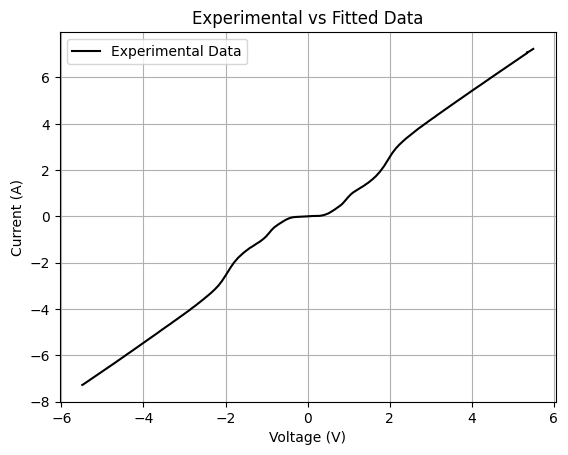

In [5]:
index = 300
I_exp = np.copy(exp['current'][index]) * h/(2*e*Delta)
V_exp = np.copy(exp['voltage_axis']) / V_gap

plt.plot(V_exp, I_exp, label="Experimental Data", color="black")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.title("Experimental vs Fitted Data")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from utilities.pincodefit import get_pincode, get_printcode
importlib.reload(sys.modules["utilities.pincodefit"])

%matplotlib qt

index = 300
I_exp = np.copy(exp['current'][index]) * h/(2*e*Delta)
V_exp = np.copy(exp['voltage_axis']) / V_gap

the_I_fit, V_theo, tau_i, the_fitness, summary = get_printcode(I_exp, V_exp, theoretical_model="carlosIV", max_number_of_channels=4, number_of_individuals=100, number_of_generations=1000)

plt.plot(V_exp, np.gradient(I_exp, V_exp, axis=0), label="Experimental Data", color="black")
plt.plot(V_theo, np.gradient(the_I_fit, V_exp, axis=0), '--',label="Fitted Data", color="red")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.title("Experimental vs Fitted Data")
plt.legend()
plt.grid()
plt.show()
tau_i, the_fitness

(array([0.6  , 0.4  , 0.175, 0.01 ]), -1.103442553115182)

: 

In [7]:
a = np.array([1,2,3,4,5,6])
a[:3], a[3:]

(array([1, 2, 3]), array([4, 5, 6]))

In [8]:
from tqdm import tqdm
exp_current = np.copy(exp['current']) * h/(2*e*Delta)
exp_voltage = np.copy(exp['voltage_axis']) / V_gap
num_voltages = exp_voltage.shape[0]

num_channel_0 = 12
exp_current_0 = exp_current[60:]
num_curves_0 = exp_current_0.shape[0]

num_channel_1 = 36
exp_current_1 = exp_current[:60]
num_curves_1 = exp_current_1.shape[0]


tau_i = np.full((np.sum([num_curves_0, num_curves_1]), max(num_channel_0, num_channel_1)), np.nan)
fitness = np.full((np.sum([num_curves_0, num_curves_1])), np.nan)
I_fit = np.full((np.sum([num_curves_0, num_curves_1]), num_voltages), np.nan)


for i in tqdm(range(num_curves_0)):
    I_exp = exp_current_0[i]
    (
    I_fit[i+num_channel_1,:], 
    V_theo, 
    tau_i[i+num_channel_1,:num_channel_0], 
    fitness[i+num_channel_1],
    ) = get_pincode(
    exp_current_0[i], 
    exp_voltage, 
    theoretical_model="carlosIV", 
    max_number_of_channels=num_channel_0, 
    number_of_individuals=200, 
    number_of_generations=600,
    )
    
for i in tqdm(range(num_curves_1)):
    I_exp = exp_current_1[i]
    (
    I_fit[i,:], 
    V_theo, 
    tau_i[i,:num_channel_1], 
    fitness[i],
    ) = get_pincode(
    exp_current_1[i], 
    exp_voltage, 
    theoretical_model="carlosIV", 
    max_number_of_channels=num_channel_1, 
    number_of_individuals=300, 
    number_of_generations=1000,
    )



100%|██████████| 60/60 [13:40<00:00, 13.67s/it]


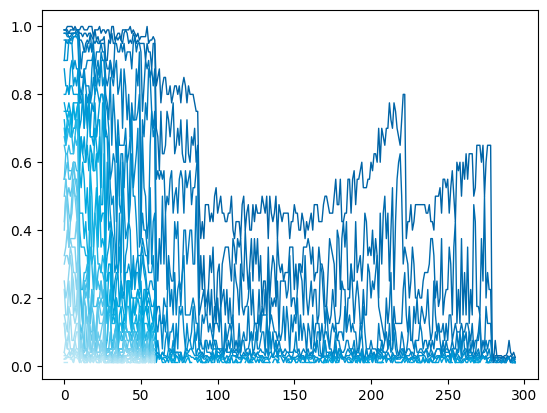

In [9]:
%matplotlib inline

shades = [cmap("seeblau")(x) for x in np.linspace(.2, .8, max(num_channel_0, num_channel_1))]

tau = np.copy(tau_i)
tau[tau==0] = np.nan

plt.figure(1)
for i in range(max(num_channel_0, num_channel_1)):    
    plt.plot(np.arange(0, tau.shape[0]), tau[:,i], '-', color=shades[i], lw=1)

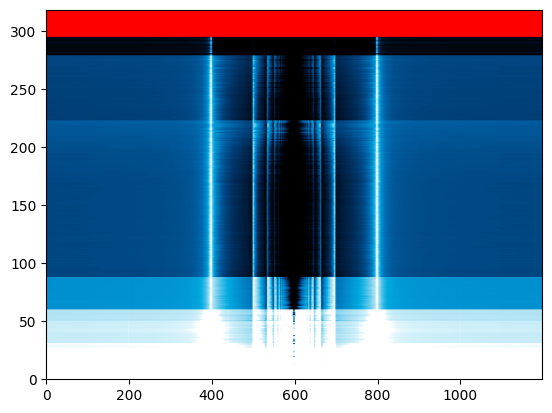

In [10]:
plt.imshow(np.gradient(I_fit, V_exp, axis=1), aspect='auto', clim=(0,9), cmap=cmap(), origin='lower')

# Animation

In [543]:
def get_Carlos_IV(file="carlosIV.pickle") -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Load Carlos IV data from a pickle file.
    Args:
        file (str): The name of the pickle file containing the data.
    Returns:
        tuple: A tuple containing the current, voltage, and transmission arrays.
    """
    with open(file, "rb") as file:
        theo = pickle.load(file)

    I_theo = np.copy(theo["current"])
    V = np.copy(theo["voltage"])
    tau = np.copy(theo["transmission"])

    return I_theo, V, tau
I_theo, V, tau = get_Carlos_IV()

generation = []
individual = []
genes = []
fitness = []
I_fit = []
for i, d in enumerate(summary):
    single_generation = int(d['generation'])
    single_individual = int(d['index'])
    single_fitness = float(d['fitness'])
    single_genes = np.array(d['genes'])
    single_I_fit = np.sum(I_theo[single_genes], axis=0)


    generation.append(single_generation)
    individual.append(single_individual)
    fitness.append(single_fitness)
    genes.append(single_genes)
    I_fit.append(single_I_fit)


generation = np.array(generation)
individual = np.array(individual)
genes = np.array(genes)
fitness = np.array(fitness)
I_fit = np.array(I_fit)

indices = np.where(np.logical_or(generation == 0, generation == max(generation)))
print(generation.shape)
generation = np.delete(generation, indices)
individual = np.delete(individual, indices)
fitness = np.delete(fitness, indices)
genes = np.delete(genes, indices, axis=0)
I_fit = np.delete(I_fit, indices, axis=0)

(1011,)


In [544]:
max(generation), max(individual), max(fitness), I_fit.shape, len(genes[0]), len(I_theo[0]), len(V), len(generation), len(individual)

(np.int64(99),
 np.int64(10),
 np.float64(-13.435033969941516),
 (989, 1198),
 9,
 1198,
 1198,
 989,
 989)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib qt

fig, [ax, ax1, ax2] = plt.subplots(1,3)


line_I_exp, = ax.plot(V_exp, I_exp, label="Experimental Data", color="red")
line_I_theo, = ax.plot(V_theo, the_I_fit, label='Final Fit', color='black')
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current (A)")
ax.set_title("Experimental vs Fitted Data (Animated)")
ax.legend()
ax.grid()

line_dIdV_exp, = ax1.plot(V_exp, np.gradient(I_exp, V_exp, axis=0), color="red")
line_dIdV_exp, = ax1.plot(V_theo, np.gradient(the_I_fit, V_theo, axis=0), color="black")

ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("dIdV (G_0)")

line_fitness_fit, = ax2.plot(generation, np.ones(np.shape(generation))*the_fitness, color='black')
# line_fitness_best, = ax2.plot(generation, np.ones(np.shape(generation))*max(fitness))

shades = [cmap("seeblau")(x) for x in np.linspace(.2, .8, max(individual))]


lines_I_fit = [ax.plot([], [], color=shades[i])[0] for i in range(max(individual))]
lines_dIdV_fit = [ax1.plot([], [], color=shades[i])[0] for i in range(max(individual))]


ax2.set_ylim(-100, 10)

FITNESS = []
FRAMES = []

def update(frame):
    logic = generation == frame
    indices = np.where(logic)[0]

    for line in lines_I_fit:
        line.set_data([], [])
    for line in lines_dIdV_fit:
        line.set_data([], [])

    ax.set_title(f"Generation: {frame}")

    i_fit = I_fit[indices][:]
    fit = fitness[indices]
    print(fit.shape)

    for i in range(len(indices)):
        lines_I_fit[i].set_data(V_theo, i_fit[i])
        lines_I_fit[i].set_color(shades[i])
        lines_dIdV_fit[i].set_data(V_theo, np.gradient(i_fit[i], V_theo, axis=0))
        lines_dIdV_fit[i].set_color(shades[i])
        ax2.scatter([np.ones(np.shape(fit))*frame], [fit], color=shades[i])

    return lines_I_fit, lines_dIdV_fit

ani = FuncAnimation(
    fig, update, frames=max(generation)+1, blit=False, repeat=False, interval=20
)

plt.show()

(0,)
(0,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(9,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


In [516]:
fitness

array([ -12372.11774255,  -20653.25503055, -110073.30487928, ...,
       -644582.6163261 , -943633.15060267,   -7476.57141575],
      shape=(99833,))

In [330]:
I_fit

array([[ -7.97313803,  -7.96032283,  -7.94750325, ...,   7.94750325,
          7.96032283,   7.97313803],
       [-12.4601258 , -12.44095708, -12.42177827, ...,  12.42177827,
         12.44095708,  12.4601258 ],
       [-14.62284984, -14.60089832, -14.57894354, ...,  14.57894354,
         14.60089832,  14.62284984],
       ...,
       [-14.84289057, -14.81992541, -14.79695442, ...,  14.79695442,
         14.81992541,  14.84289057],
       [-18.16326768, -18.1363738 , -18.1094678 , ...,  18.1094678 ,
         18.1363738 ,  18.16326768],
       [-18.97192525, -18.94257344, -18.91321449, ...,  18.91321449,
         18.94257344,  18.97192525]], shape=(4509, 1198))

In [177]:
max(individual)

np.int64(99)

In [134]:
int(np.max(generation))

1000

In [117]:
cmap(1)

KeyError: 1

In [122]:

my_cmap = cmap("seeblau")
shades = [my_cmap(x) for x in np.linspace(.2, .8, 4)]
for i, color in enumerate(shades):
    plt.plot([0, 1], [i, i], color=color, linewidth=8)
plt.show()

In [ ]:
import pickle
import numpy as np
from pygad import GA as GeneticAlgorithm
from functools import partial


class TheoreticalIV(IVEvaluation):
    """
    Class to find the pincode of an IV based on a theoretical model.
    Inherits from IVEvaluation.
    """

    def __init__(self, name: str = "theo", *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.name = name
    



        self.theoretical_model = {
            name: "",
            I_theo: None,
            V_theo: None,
            tau: None,
        }

        
    




def get_i_theo_from_genes(genes:np.ndarray, I_theo:np.ndarray) -> np.ndarray:  
    """
    genes: 1D array of integers [0 up to len(transmission)] with length max_number_of_channels
    """
    return np.sum(I_theo[genes, :], axis=0)

def error_function(i_theo:np.ndarray, i_exp:np.ndarray) -> float:
    return np.sum((i_theo - i_exp)**2)


def get_fitness_from_i_exp_and_I_theo(ga, genes, index_of_individum, i_exp:np.ndarray, I_theo:np.ndarray) -> float:
    i_theo = get_i_theo_from_genes(genes, I_theo)
    fitness = - error_function(i_theo, i_exp)
    return fitness

def get_pincode(I_exp: np.ndarray,
                V_exp: np.ndarray, 
                theoretical_model: str = "carlosIV", 
                max_number_of_channels: int = 10, 
                number_of_individuals: int = 100, 
                number_of_generations: int = 1000,
                ):
    """
    Finds pincode of IV based on the theoretical model.
    
    Args:
        I_exp (np.ndarray): Experimental current data.
        V_exp (np.ndarray): Experimental voltage data.
        theoretical_model (callable): Theoretical model function.
        max_number_of_channels (int): Maximum number of channels.
        number_of_individuals (int): Number of individuals in the population.
        number_of_generations (int): Number of generations for the genetic algorithm.
    
    Returns:
        np.ndarray: I_theo: The theoretical IV
        np.ndarray: V_theo: Theoretical voltage values
        np.ndarray: pincode: The pincode for the IV
        np.ndarray: error: The error of the fit
    """


    # Load theoretical model
    if theoretical_model == "carlosIV":
        I_theo, V_theo, tau = get_Carlos_IV()
    else:
        raise ValueError(f"Unknown theoretical model: {theoretical_model}")
    
    i_exp, _ = bin_y_over_x(V_exp, I_exp, V_theo)

    # Run GA
    ga = GeneticAlgorithm(
        sol_per_pop=number_of_individuals,
        num_parents_mating=int(number_of_individuals / 2),
        num_generations=number_of_generations,
        fitness_func=partial(get_fitness_from_i_exp_and_I_theo, i_exp=i_exp, I_theo=I_theo),
        num_genes=max_number_of_channels,
        gene_type=int,
        init_range_low=0,
        init_range_high=len(tau),
        gene_space=list(range(len(tau))),
        mutation_percent_genes='default',
        # mutation_num_genes='default',
        # mutation_num_genes=max_number_of_channels,
        mutation_type="random",
        crossover_type="single_point"
    )

    ga.run()

    solution, fitness, _ = ga.best_solution()

    error = -fitness  # Since we minimized the error function, we negate it to get the error value

    indices = np.argsort(-solution)
    solution = solution[indices]
    tau = tau[indices]
    i_theo = get_i_theo_from_genes(solution, I_theo)

    return i_theo, V_theo, tau, error

In [239]:
index = 0
I_exp = np.copy(exp['current'][index]) * h/(2*e*Delta)
V_exp = np.copy(exp['voltage_axis']) / V_gap

I_theo, V_theo, tau, error = get_pincode(I_exp, V_exp, theoretical_model="carlosIV", max_number_of_channels=10, number_of_individuals=100, number_of_generations=1000)



Best solution: [11  4 11 11  9  9  0 10  9 10], Fitness: -4596111.53458092


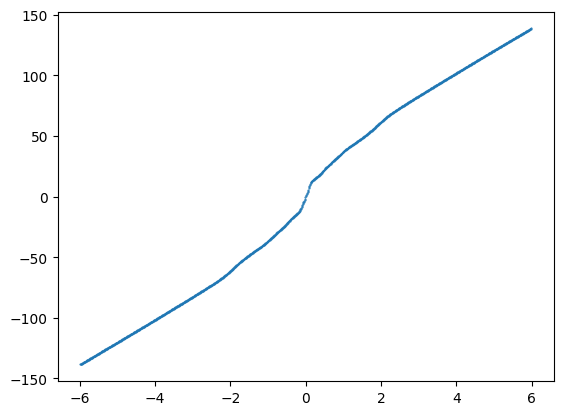

In [240]:
plt.plot(V_exp, I_exp, '.',ms = 1, label="Experimental IV")


In [521]:
import pygad

# Parameters
max_number_of_channels = 20
number_of_individuals = 200
number_of_generations = 2000
number_of_genes = max_number_of_channels

# Data
tau = np.copy(theo['transmission'])
V = np.copy(theo['voltage'])
I_theo = np.copy(theo['current'])

indices = np.argsort(tau)
tau = tau[indices]
I_theo = I_theo[indices, :]

index = 10
i_exp = np.copy(exp['current'][index]) * h/(2*e*Delta)



# Run GA
ga = pygad.GA(
    sol_per_pop=number_of_individuals,
    num_parents_mating=int(number_of_individuals / 2),
    num_generations=number_of_generations,
    fitness_func=fitness_function,
    num_genes=number_of_genes,
    gene_type=int,
    init_range_low=0,
    init_range_high=len(tau),
    gene_space=list(range(len(tau))),
    mutation_percent_genes='default',
    # mutation_num_genes='default',
    # mutation_num_genes=max_number_of_channels,
    mutation_type="random",
    crossover_type="single_point"
)

ga.run()

# Result
solution, fitness, _ = ga.best_solution()

indices = np.argsort(-solution)
solution = solution[indices]

# ga.summary()


theo_label = r'$\tau_i = \{$'
theo_label += ', '.join([f'{tau[i]:.2f}' for i in solution])
theo_label += r'$\}$'
# Plot
i_theo = get_i_theo(solution)
# tau_i = transmissions[solution]
plt.plot(V, i_exp, label='exp', linewidth=2)
plt.plot(V, i_theo, '--', label=theo_label, linewidth=2)
plt.legend()
plt.grid()
plt.show()

tau[solution], fitness

NameError: name 'theo' is not defined

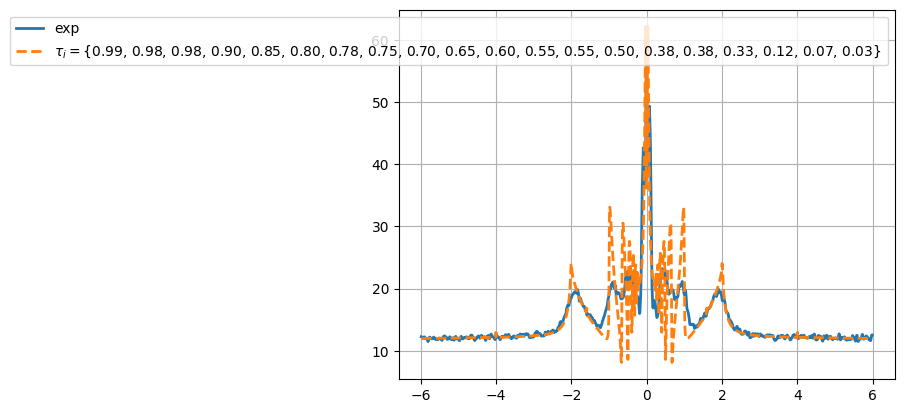

(array([0.99 , 0.98 , 0.98 , 0.9  , 0.85 , 0.8  , 0.775, 0.75 , 0.7  ,
        0.65 , 0.6  , 0.55 , 0.55 , 0.5  , 0.375, 0.375, 0.325, 0.125,
        0.075, 0.03 ]),
 np.float64(-31.053046630088012))

In [68]:
theo_label = r'$\tau_i = \{$'
theo_label += ', '.join([f'{tau[i]:.2f}' for i in solution])
theo_label += r'$\}$'
# Plot
i_theo = get_i_theo(solution)
# tau_i = transmissions[solution]
plt.plot(V, np.gradient(i_exp, V), label='exp', linewidth=2)
plt.plot(V, np.gradient(i_theo, V), '--', label=theo_label, linewidth=2)
plt.legend()
plt.grid()
plt.show()

tau[solution], fitness

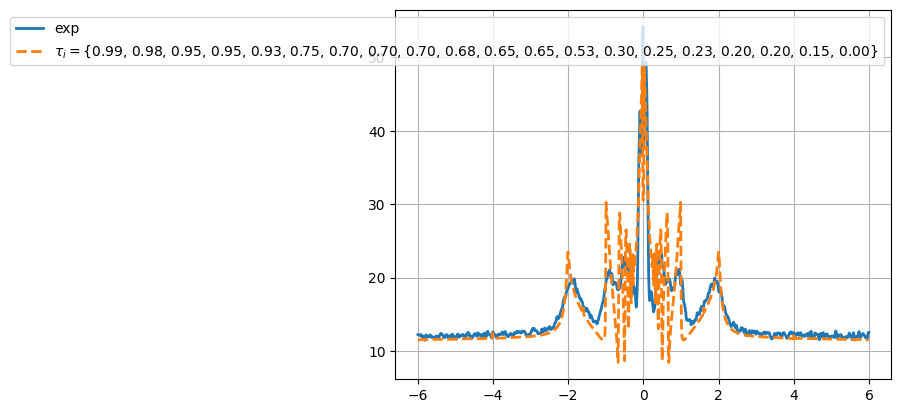

(array([0.99 , 0.98 , 0.95 , 0.95 , 0.925, 0.75 , 0.7  , 0.7  , 0.7  ,
        0.675, 0.65 , 0.65 , 0.525, 0.3  , 0.25 , 0.225, 0.2  , 0.2  ,
        0.15 , 0.   ]),
 np.float64(-8896.431649709131))

In [70]:
import pygad

# Parameters
max_number_of_channels = 20
number_of_individuals = 200
number_of_generations = 2000
number_of_genes = max_number_of_channels

# Data
tau = np.copy(theo['transmission'])
V = np.copy(theo['voltage'])
dIdV_theo = np.copy(theo['dIdV'])

indices = np.argsort(tau)
tau = tau[indices]
dIdV_theo = dIdV_theo[indices, :]

index = 10
didv_exp = np.copy(exp['differential_conductance'][index])


def get_didv_theo(genes:np.ndarray) -> np.ndarray:  
    """
    genes: 1D array of integers [0 up tp len(transmission)] with length max_number_of_channels
    """
    return np.sum(dIdV_theo[genes, :], axis=0)

def error_function(didv_theo):
    return np.sum((didv_theo - didv_exp)**2)

def fitness_function(ga, genes, index_of_individum):
    didv_theo = get_didv_theo(genes)
    fitness = - error_function(didv_theo)
    return fitness



def genetic_algorithm(
        I_exp,
        max_number_of_channels=100, 
        number_of_individuals=200, 
        number_of_generations=2000,
        theory='CarlosIV',
        ):
    """
    Runs a genetic algorithm to optimize the selection of channels.
    
    Parameters:
    - max_number_of_channels: Maximum number of channels to select.
    - number_of_individuals: Number of individuals in the population.
    - number_of_generations: Number of generations to run the GA.
    
    Returns:
    - solution: Best solution found by the GA.
    - fitness: Fitness of the best solution.
    """
    # Run GA
    ga = pygad.GA(
        sol_per_pop=number_of_individuals,
        num_parents_mating=int(number_of_individuals / 2),
        num_generations=number_of_generations,
        fitness_func=fitness_function,
        num_genes=max_number_of_channels,
        gene_type=int,
        init_range_low=0,
        init_range_high=len(tau),
        gene_space=list(range(len(tau))),
        mutation_percent_genes='default',
        mutation_type="random",
        crossover_type="single_point"
    )

    ga.run()
    
    # Result
    solution, fitness, _ = ga.best_solution()
    
    indices = np.argsort(-solution)
    solution = solution[indices]
    
    return solution, fitness

# Run GA
ga = pygad.GA(
    sol_per_pop=number_of_individuals,
    num_parents_mating=int(number_of_individuals / 2),
    num_generations=number_of_generations,
    fitness_func=fitness_function,
    num_genes=number_of_genes,
    gene_type=int,
    init_range_low=0,
    init_range_high=len(tau),
    gene_space=list(range(len(tau))),
    mutation_percent_genes='default',
    # mutation_num_genes='default',
    # mutation_num_genes=max_number_of_channels,
    mutation_type="random",
    crossover_type="single_point"
)

ga.run()

# Result
solution, fitness, _ = ga.best_solution()

indices = np.argsort(-solution)
solution = solution[indices]

# ga.summary()


theo_label = r'$\tau_i = \{$'
theo_label += ', '.join([f'{tau[i]:.2f}' for i in solution])
theo_label += r'$\}$'
# Plot
didv_theo = get_didv_theo(solution)
# tau_i = transmissions[solution]
plt.plot(V, didv_exp, label='exp', linewidth=2)
plt.plot(V, didv_theo, '--', label=theo_label, linewidth=2)
plt.legend()
plt.grid()
plt.show()

tau[solution], fitness

In [108]:
solution

array([1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0])

In [73]:

pygad.__version__

'3.3.1'

In [ ]:

    
    # conduction_fit = np.sum(transmissions[solution])
    # if np.abs(conduction_fit - conduction) > conduction_threshold:
    #     return 0
    
    # y_fit = np.sum(X[:, solution], axis=1)
    # fitness = - error_function(y_fit, y)
    # return fitness
    
    # mask = np.round(solution).astype(bool)
    # if np.sum(mask) == 0 or np.sum(mask) > k_max:
    #     return -1e6  # Penalize invalid
    # y_fit = X[:, mask].sum(axis=1)
    # error = np.linalg.norm(y - y_fit)
    # return -error  # pygad maximizes → we minimize error

# selected = np.where(np.round(solution) == 1)[0]
# print(f"Selected curve indices: {selected}")
# print(f"Fitness (negative error): {fitness:.4f}")


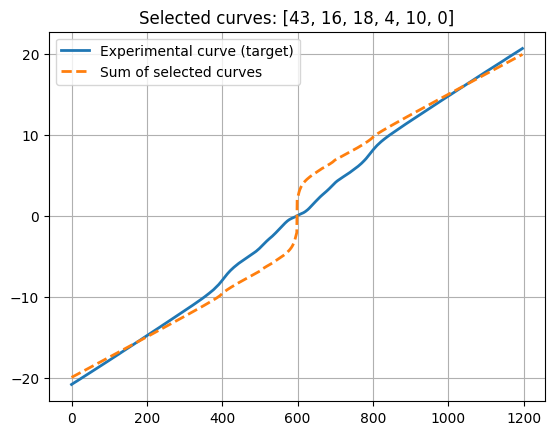

In [153]:
X = I_theo
y = I_exp

# Greedy 0/1 selection algorithm
k = 6  # max number of curves to use
selected = []
residual = y.copy()
remaining = set(range(X.shape[1]))

for _ in range(k):
    best_idx = None
    best_error = np.inf
    for i in remaining:
        candidate = selected + [i]
        trial_sum = X[:, candidate].sum(axis=1)
        error = np.linalg.norm(y - trial_sum)
        if error < best_error:
            best_error = error
            best_idx = i
    if best_idx is not None:
        selected.append(best_idx)
        remaining.remove(best_idx)

# Compute final fit
I_fit = X[:, selected].sum(axis=1)
# Plot results
plt.plot(y, label='Experimental curve (target)', linewidth=2)
plt.plot(I_fit, label='Sum of selected curves', linestyle='--', linewidth=2)
plt.legend()
plt.title(f"Selected curves: {selected}")
plt.grid(True)
plt.show()

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47}

In [143]:

from sklearn.linear_model import orthogonal_mp

coef = orthogonal_mp(I_theo, I_exp, n_nonzero_coefs=6)

In [146]:
for i, c in enumerate(coef):
    if c != 0:
        print(f"{c} * {transmissions[i]}")

0.27848561387234716 * 0.99
-0.11895006444738446 * 0.7000000000000001
2.066999972224277 * 0.85
-0.43619802230907573 * 0.9500000000000001
-0.0435146129224838 * 1.0
4.079031572582105 * 0.35000000000000003


In [141]:
where_not_zero = (coef !=0)
tau_i = transmissions[where_not_zero]
tau_i = np.flip(np.sort(tau_i))

I_theo_fitted = np.sum(I_theo[:,where_not_zero], axis=1)

# # indices = np.argsort(coef)
# # coef = coef[indices]
# # tau = tau[indices]
# # tau

# coef, tau

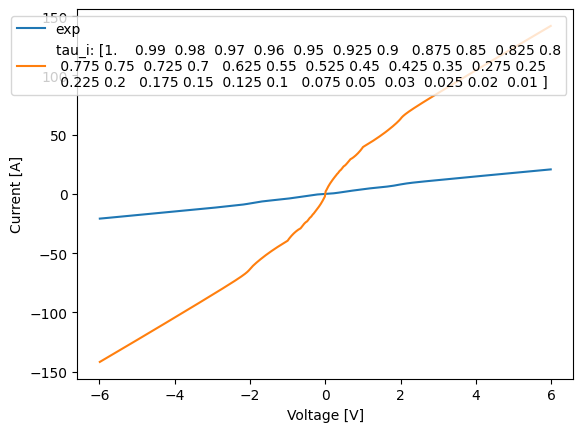

In [142]:
plt.plot(voltage, I_exp, label='exp')
plt.plot(voltage, I_theo_fitted, label=f'tau_i: {tau_i}')

plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.legend()

In [63]:
tau

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 1.  , 0.35, 0.7 ])

In [ ]:
from sklearn.linear_model import Lasso

# X: each column is a theoretical curve (shape: [n_points, n_curves])
# y: experimental curve (shape: [n_points])
X = I_theo.T
y = I_exp

model = Lasso(alpha=0.01)  # alpha controls sparsity
model.fit(X, y)

coefficients = model.coef_
selected_curves = np.nonzero(coefficients)[0]  # indices of non-zero curves
fit = model.predict(X)

In [ ]:
from time import time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

t0 = time()
lasso = Lasso(alpha=0.14).fit(X, y)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}")

In [41]:
coefficients


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])